In [ ]:
# Mount my Google Drive to Collaboratory
from google.colab import drive 
drive.mount('/content/gdrive')

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from pandas import concat

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

from IPython.display import display, HTML, display_html
import calendar
import datetime
import math
import pickle
import holidays

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Jack QC Dataset.csv').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
headers = rows.pop(0)

df = pd.DataFrame(rows, columns=headers)
df.head()

,Date,Total_Revenue
0,2018-04-01,3885.88
1,2018-04-02,643.45
2,2018-04-03,370.94
3,2018-04-04,2624.68
4,2018-04-05,4393.24


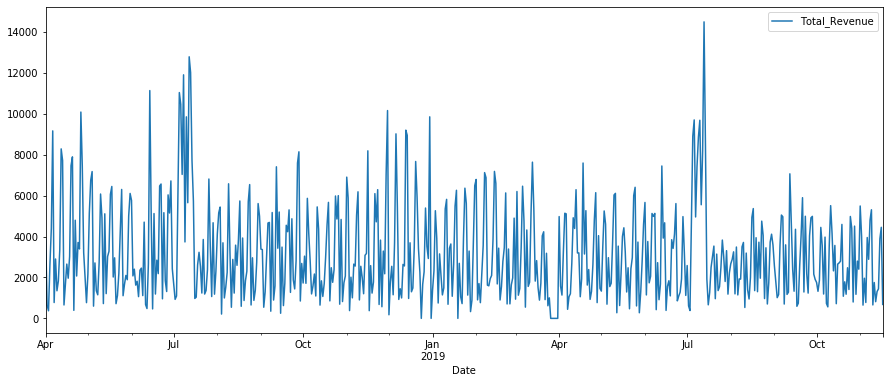

In [ ]:
# Cleansing and exploring:
df=df.replace({'\$': '', ',': '', ' ': ''}, regex=True)
df['Total_Revenue']= df['Total_Revenue'].astype(float)
# Make the Date column as a timestamps:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df=df.set_index('Date')
df.plot()

In [ ]:
df.isnull().values.any()

False

In [ ]:
df.describe()

,Total_Revenue
count,596.000000
mean,3202.430302
std,2368.813315
min,0.000000
25%,1289.497500
50%,2652.120000
75%,4708.030000
max,14493.100000


#  Time Series Features Engineering


In [ ]:
# parse the date column to 3 columns, year, month and day
df=df.reset_index()
df['Date']= pd.to_datetime(df['Date'])
# Get the month from the date
df['month'] = df['Date'].dt.month
# Get the day of week name:
df['dayofweek_name'] = df['Date'].dt.weekday_name
df['dayofweek'] = df['Date'].dt.weekday
print(df.tail(60))

          Date  Total_Revenue  month dayofweek_name  dayofweek
536 2019-09-19        2582.44      9       Thursday          3
537 2019-09-20        4055.85      9         Friday          4
538 2019-09-21        5899.15      9       Saturday          5
539 2019-09-22        1288.44      9         Sunday          6
540 2019-09-23        4991.60      9         Monday          0
541 2019-09-24        2182.86      9        Tuesday          1
542 2019-09-25        1235.38      9      Wednesday          2
543 2019-09-26        4034.70      9       Thursday          3
544 2019-09-27        4917.19      9         Friday          4
545 2019-09-28        4986.45      9       Saturday          5
546 2019-09-29        2158.52      9         Sunday          6
547 2019-09-30        1902.21      9         Monday          0
548 2019-10-01        1755.66     10        Tuesday          1
549 2019-10-02        1323.14     10      Wednesday          2
550 2019-10-03        1849.74     10       Thursday    

# Dealing with missing values:

In [ ]:
df = df.set_index('Date')
# mark zero values as missing or NaN
df['Total_Revenue'] = df['Total_Revenue'].replace(0, np.NaN)
# count the number of NaN values in each column
print(df.isnull().sum())
# fill missing values with a value at the same day one week ago
# df['Total_Revenue'] = df['Total_Revenue'].fillna(df['Total_Revenue'].shift(7))
# Fill those nan values with the mean of all data at that day of week:
df["Total_Revenue"]= df.groupby("dayofweek_name").transform(lambda x: x.fillna(x.mean())).astype(float)
print(df.isnull().sum())

Total_Revenue     9
month             0
dayofweek_name    0
dayofweek         0
dtype: int64
Total_Revenue     0
month             0
dayofweek_name    0
dayofweek         0
dtype: int64


In [ ]:
df.describe()

,Total_Revenue,month,dayofweek
count,596.000000,596.000000,596.000000
mean,3249.052836,6.827181,3.005034
std,2340.147645,3.048405,2.003772
min,176.050000,1.000000,0.000000
25%,1326.087500,4.000000,1.000000
50%,2695.610000,7.000000,3.000000
75%,4754.765000,9.000000,5.000000
max,14493.100000,12.000000,6.000000


In [ ]:
df_diff=df['Total_Revenue'].diff()
df_diff.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20)

NameError: ignored

In [ ]:
df_diff=df_diff.reset_index()
df_diff['Date']= pd.to_datetime(df_diff['Date'])
# Get the month from the date
df_diff['month'] = df_diff['Date'].dt.month
# Get the day of week name:
df_diff['dayofweek_name'] = df_diff['Date'].dt.weekday_name
df_diff['dayofweek'] = df_diff['Date'].dt.weekday

## Detecting the outliers for each month of the year:


In [ ]:
sns.boxplot(data=df_diff, x='month', y='Total_Revenue', whis=1.5)

In [ ]:
monthofyear = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
all_filters_month = []
def outliers_filter_month(month):
  df_month=df_diff['Total_Revenue'][df_diff['month'] == month]
  df_month= pd.Series(df_month).to_frame()

  Q1 = df_month['Total_Revenue'].quantile(0.25)
  Q3 = df_month['Total_Revenue'].quantile(0.75)
  IQR = Q3 - Q1
  month_filter = (df_month['Total_Revenue'] >= Q1 - 1.5 * IQR) & (df_month['Total_Revenue'] <= Q3 + 1.5 *IQR)
  all_filters_month.append(month_filter)

for m in monthofyear:
    outliers_filter_month(m)

## Detecting the outliers for each day of week:


In [ ]:
sns.boxplot(data = df_diff, x = 'dayofweek_name', y='Total_Revenue', whis=1.5)

In [ ]:
dayofweek = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
all_filters_day = []
def outliers_filter(day):
  df_day=df_diff['Total_Revenue'][df_diff['dayofweek_name'] == day]
  df_day= pd.Series(df_day).to_frame()

  Q1 = df_day['Total_Revenue'].quantile(0.25)
  Q3 = df_day['Total_Revenue'].quantile(0.75)
  IQR = Q3 - Q1
  day_filter = (df_day['Total_Revenue'] >= Q1 - 1.5 * IQR) & (df_day['Total_Revenue'] <= Q3 + 1.5 *IQR)
  all_filters_day.append(day_filter)

for d in dayofweek:
    outliers_filter(d)

In [ ]:
df_diff['outliers_filter_day'] =pd.concat(all_filters_day, axis=0, join='outer')
df_diff['outliers_filter_month'] =pd.concat(all_filters_month, axis=0, join='outer')
df_diff['outliers_filter'] =  (df_diff['outliers_filter_day']) & (df_diff['outliers_filter_month'])
df_diff = df_diff.drop(df_diff[['outliers_filter_day', 'outliers_filter_month']], axis = 1)

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 1000)
print(df_diff)

In [ ]:
df_outliers=df_diff['Total_Revenue'][df_diff['outliers_filter']== False]
print(df_outliers.head(60))
df_outliers.plot(marker = '*')

# Extract features:

In [ ]:
df_diff = df_diff.reset_index()

In [ ]:
def addAvgToDF(days):
  for index, row in df_diff.head(len(df_diff)).iterrows():
    currentIndex = index
    daysConsidered = 0
    total = 0
    while currentIndex > -1 and daysConsidered < days:
      currentIndex = currentIndex - 7
      if currentIndex > -1 and df_diff.iloc[currentIndex]["outliers_filter"]:
        total += df_diff.iloc[currentIndex]["Total_Revenue"]
        daysConsidered = daysConsidered+1

    if daysConsidered != 0 and total > 0:
      df_diff.at[index,'avg_'+str(days)] = total / daysConsidered;


pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 1000)
addAvgToDF(4);
addAvgToDF(12);

In [ ]:
# Rename the date column:
df_diff.rename(columns={'Date':'date_time'}, inplace=True)
df_diff = df_diff.set_index('date_time')
df_diff.head(60)

# Dealing with outliers by replace them with the average of previous 4 values at the same day of week:

In [ ]:
df_diff['Total_Revenue'] = np.where(df_diff['outliers_filter']==False, df_diff['avg_4'], df_diff['Total_Revenue'])
print(df_diff.head(60))

# Extract Cyclic features for day of month and day of week:

In [ ]:
df_diff['month_sin'] = np.sin((df_diff.month-1)*(2.*np.pi/12))
df_diff['month_cos'] = np.cos((df_diff.month-1)*(2.*np.pi/12))
df_diff['dayofweek_sin'] = np.sin((df_diff.dayofweek-1)*(2.*np.pi/7))
df_diff['dayodweek_cos'] = np.cos((df_diff.dayofweek-1)*(2.*np.pi/7))

# Extract Rolling Window Feature:

In [ ]:
df['Rolling_7'] = df['Total_Revenue'].rolling(7, center=True).mean()

# Extract Expanding Window Features:

In [ ]:
Rev = df_diff['Total_Revenue']
window = Rev.expanding()
dataframe = concat([window.min(), window.mean(), window.max(), Rev.shift(-1)], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']
print(dataframe.head())

In [ ]:
df = pd.concat([dataframe, df_diff], axis=1, join = 'inner')
df = df.reset_index()
pd.set_option('display.max_columns', 1000)
print(df.head())

# Adding Weather features (meteorological):

In [ ]:
# Install the package:
!pip install wwo-hist
# Import package
from wwo_hist import retrieve_hist_data
# Set working directory to store output csv file(s)
import os
os.chdir("/content")

In [ ]:
# getting current date and time
d = datetime.datetime.today()

In [ ]:
frequency= 4    #I need the weather data to be each 4 hours
start_date = '01-December-2017'
end_date = d  # I want one year ahead
api_key = 'd7c546c0659349f3a3b152037201301'
location_list = ['G1R3J6']

hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)

In [ ]:
Weather=pd.read_csv('G1R3J6.csv')
Weather.head(10)

In [ ]:
# Keep only the Columns I need:
Weather=Weather[['date_time', 'FeelsLikeC', 'cloudcover', 'totalSnow_cm', 'visibility', 'precipMM', 'windspeedKmph']]
Weather['date_time'] = pd.to_datetime(Weather['date_time'], errors='coerce')
Weather = Weather.set_index('date_time')
print(Weather)

In [ ]:
# I need only the rows which give the weather data for opening hours (9 - 21):
Weather = Weather.between_time('09:00:00','21:00:00')
# Aggregate the data by day with the following conditions:
Weather = Weather.resample('D').agg({'totalSnow_cm':'max', 'FeelsLikeC':'mean', 'cloudcover':'mean', 'visibility': 'max', 'precipMM': 'max', 'windspeedKmph': 'mean'})
print(Weather.head(10))

In [ ]:
# Convert the weather data to categorical features:
temp_bins = [-34, -17, 10, 22, 45]
temp_labeles = ['frigid', 'cold', 'fine', 'hot']
Weather['TempRange'] = pd.cut(Weather['FeelsLikeC'], bins=temp_bins, labels=temp_labeles)

snow_bins = [-1, 3, 6, 15, 40]
snow_labeles = ['no_snow', 'light_snow', 'heavy_snow', 'storm']
Weather['SnowRange'] = pd.cut(Weather['totalSnow_cm'], bins=snow_bins, labels=snow_labeles)

cloud_bins = [-1, 14, 48, 95, 101]
cloud_labeles = ['sunny', 'partly sunny', 'cloudy', 'fog']
Weather['CloudRange']= pd.cut(Weather['cloudcover'], bins=cloud_bins, labels=cloud_labeles)

wind_bins = [0, 8, 15, 30, 40]
wind_labeles = ['no_wind', 'breez', 'windy', 'stormy']

Weather['WindRange']= pd.cut(Weather['windspeedKmph'], bins=wind_bins, labels=wind_labeles)
Weather = Weather.reset_index()
print(Weather.head())

In [ ]:
for index, row in Weather.head(len(Weather)).iterrows():
  if Weather.iloc[index]["TempRange"] == 'frigid' or Weather.iloc[index]['WindRange'] == 'stormy' and Weather.iloc[index]['CloudRange'] == 'fog':
    Weather.at[index,'weather'] = "frigid"
  elif Weather.iloc[index]['SnowRange'] == 'storm' or (Weather.iloc[index]['visibility'] >=10 and Weather.iloc[index]['SnowRange'] == 'heavy_snow') or (Weather.iloc[index]['precipMM'] >= 4 and Weather.iloc[index]['SnowRange']=='heavy_snow') or (Weather.iloc[index]["TempRange"] == 'frigid' and Weather.iloc[index]["visibility"] >= 10):
   Weather.at[index,'weather'] = "Storm"
  elif Weather.iloc[index]["precipMM"] >=7:
    Weather.at[index,'weather'] = "Rainy_day"
  elif Weather.iloc[index]["WindRange"] == 'stormy':
    Weather.at[index,'weather'] = "windy"
  elif (Weather.iloc[index]['TempRange'] == 'hot') or (Weather.iloc[index]['TempRange'] == 'hot' and Weather.iloc[index]['WindRange'] == 'no_wind' and Weather.iloc[index]['CloudRange'] == 'sunny'):
    Weather.at[index,'weather'] = 'canicular day'
  else:
    Weather.at[index,'weather'] = "nice_weather"

print(Weather)


In [ ]:
# Add the new weather features to the main dataframe
features = pd.concat([df.set_index('date_time'),Weather.set_index('date_time')], axis=1, join='inner').reset_index()

# Adding Holiday features:

In [ ]:
QC_holidays = holidays.CountryHoliday('CA', prov='QC')
for date, name in sorted(holidays.CA(state='QC', years=[2017, 2018, 2019]).items()):
  print(date, name)

In [ ]:
Satutory_holidays = pd.DataFrame({
  'holiday': 'Yes',
  'date_time': pd.to_datetime(['2017-09-04', '2017-10-09', '2017-11-25', '2017-12-25', '2017-12-26',
                        '2018-01-01', '2018-02-19', '2018-03-30', '2018-05-21',
                        '2018-07-01', '2018-08-06', '2018-09-03', '2018-10-08', '2018-12-24',
                        '2018-12-25', '2018-12-26', '2019-01-01', '2019-02-18', '2019-04-19',
                        '2019-05-20', '2019-07-01', '2019-08-05', '2019-09-02',
                        '2019-10-14', '2019-12-24', '2019-12-25', '2019-12-26'])})

In [ ]:
# Add the new holiday feature to the main dataframe
df = features.merge(Satutory_holidays, how='left', left_on='date_time', right_on='date_time')

# Now I want that a column displays when there is a holiday or not with ("1" or "0"). So I did the following:
df['holiday'].replace(['Yes'],[1],inplace=True)
df['holiday'].replace([float('nan')],[0],inplace=True)

print(df.head())

# Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

The simplest approach is to predict the value at the next time (t+1) given the value at the previous time (t-1). 
As I need to redict the next 14 value of only one variable (total_revenue) so that I will shift only this cloumn.

In [ ]:
df = df.drop(['month', 'dayofweek', 'dayofweek_name', 'outliers_filter', 'FeelsLikeC', 'cloudcover', 'totalSnow_cm',
       'visibility', 'precipMM', 'windspeedKmph', 'TempRange', 'SnowRange',
       'CloudRange', 'WindRange'], axis=1)
df.head(30)

In [ ]:
df_laged = pd.concat([df, df['Total_Revenue'].shift(7)], axis=1)
df_laged = df_laged.set_index('date_time')
df_laged.columns

In [ ]:
df_laged.columns = ['min', 'mean', 'max', 't+1', 'Revenue', 'avg_4weeks',
       'avg_12weeks', 'm_sin', 'm_cos', 'dow_sin',
       'dow_cos', 'Rolling_7', 'weather', 'holiday', 'lag_7']
print(df_laged.head())

In [ ]:
df_laged['Revenue'][:300].plot(marker = "^")

In [ ]:
# Drop the NaN rows:
df_laged = df_laged.dropna(how='any')
df_laged.head(10)

# Hot coding for weather feature:

In [ ]:
dummy = pd.get_dummies(df_laged['weather'])
df = pd.concat([df_laged, dummy], axis=1)
df = df.drop(['weather'], axis=1)
df.head()

# Studing feature importance:

In [ ]:
f, ax = plt.subplots(figsize = (18, 10))
sns.heatmap(df_laged.corr(),ax = ax, annot=True, cmap=sns.diverging_palette(10, 133, as_cmap=True), linewidths=0.5)

In [ ]:
# df = df[['Revenue', 'dow_sin', 'lag_7', 'Rainy_day',	'Storm',	'canicular day',	'frigid',	'nice_weather', 'holiday']]

# Studing data distribution:

In [ ]:
df['Revenue'].hist(bins=20, figsize=(10,5))
plt.show()

# Splitting the data into training, validation and testing:

In [ ]:
# I will always keep the last two months of the dataset for testing my model (60 days)
df_test = df[-60:]
dataTestX = df_test.drop(['Revenue'], axis=1)
dataTestX = np.array(dataTestX) # convert to numpy array :

dataTestY = df_test['Revenue'].values
df_train = df[:-60]
dataX = df_train.drop(['Revenue'], axis=1).as_matrix()
dataY = df_train[['Revenue']].values

In [ ]:
y_mean = dataY.mean()
# y_std = np.sqrt(dataY.std())
y_std = 1.02

In [ ]:
y_mean

In [ ]:
y_std

In [ ]:
dataYTouse = (dataY-y_mean)/y_std

In [ ]:
print(max(dataYTouse) - min(dataYTouse))

# Applying the model after normalizing the data:

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
SC = MinMaxScaler(feature_range=(0, 1))
tscv = TimeSeriesSplit(max_train_size=None, n_splits=21)
model = SGDRegressor(random_state=1, warm_start= True, early_stopping =True, alpha=0.001, penalty="l1", max_iter=1000, tol=0.001, eta0=0.1, power_t=0.264, n_iter_no_change= 15)

def sample(df):
  index = 1
  for train_index, valid_index in tscv.split(dataX):
    print("TRAIN:", len(train_index), "VALID:", len(valid_index))

    dataTrainX, datavalidX = dataX[train_index], dataX[valid_index]
    dataTrainY, datavalidY = dataYTouse[train_index], dataYTouse[valid_index]
    
    dataTrainX_scalled = SC.fit_transform(dataTrainX) # fit only on train
    dataTestX_scalled = SC.transform(dataTestX)
    datavalidX_scalled = SC.transform(datavalidX)
 
    model.fit(dataTrainX_scalled, dataTrainY.ravel())
    y_hat = model.predict(datavalidX_scalled)
    mae = mean_absolute_error((datavalidY+y_mean)*y_std, (y_hat+y_mean)*y_std)
    print('mae = {:0.1f}'.format(mae))
    mase = sqrt(mean_squared_error((datavalidY+y_mean)*y_std, (y_hat+y_mean)*y_std))
    print('mase = {:0.1f}'.format(mase))

  return dataTrainX_scalled, dataTrainY, dataTestX_scalled, dataTestY

dataTrainX_scalled, dataTrainY, dataTestX_scalled, dataTestY = sample(df)

model.fit(dataTrainX_scalled, dataTrainY)

predicted = (model.predict(dataTestX_scalled)+y_mean)*y_std

results = pd.DataFrame({'Revenues':dataTestY[-90:], 'y_hat':predicted[-90:]})
print(results)
dfTestWithIndex = df_test.reset_index()
df_results = pd.concat([results, dfTestWithIndex], axis=1).set_index('date_time')
df_results = df_results.drop(['Revenue'], axis=1)

abs_errors = abs(dataTestY - predicted)
MAPE = (abs_errors / dataTestY) * 100
df_results['MAPE']= MAPE
print(df_results.tail(60))

fig = plt.figure()
plt.plot(results['Revenues'][-90:], 'Red')
plt.plot(results['y_hat'][-90:], 'Blue')
print('Mean Absolute Error on testing dataset = {:0.1f}'.format(mean_absolute_error(dataTestY, predicted)))
print('Root Mean Square Error on testing dataset = {:0.1f}'.format(sqrt(mean_squared_error(dataTestY, predicted))))